# BreastMammaryTissueJunctionAnalysis as a Notebook 

rMATS 3.2.5 was run on controlled access RNASeq files retrieved experiments stored in the Sequence Read Archive with controlled access managed by dbGaP.   The data were generated under the Gene Tissue Expression.

## rMATS RNASeq-MATS.py produces 10 different output types which get assembled into as type junction ID by sample ID matrices

### Alternative Splice Site Types are: (se, a3ss, a5ss, mxe, ri)

 This is input as ARGV1 into variable 'astype'

  * Skipped Exon events (se),
  * Alternative 3' splice site (a3ss),
  * Alternative 5' splice site (a5ss),
  * Mutually exclusive exon (mxe),
  * and retention intron (ri)

### There are two different kinds of junction counts

  * jc = junction counts - reads that cross the junction
  * jcec = junction counts plus reads on the target (such as included exon

### And the count type -- there are 5 types

  * inclusion levels (percent spliced in)
  * included junction counts (ijc)
  * skipped junction counts (sjc)
  * inclusion length (inclen)
  * skipped length (skiplen)

### function: fit_iso_tissue 

fit_iso_tissue expects the following input:

  * the tissue of interest (SMSTD) 
  * an ordered_merged_rmats -- which will be ordered to fit the count matrix
  * count matrix (inc or ijc & sjc merged)
  * splice type (a3ss, a5ss, mxe, ri or se)
  * junction_count type (jc or jcec)
  * count type (inc or the merged ijc,sjc)
  
### reordering to match annotations between count matrix and annotation matrix

Common problem is to match specifically the rows of an annotation matrix with the columns of a count matrix
`match` is the function that gives the re-ordering index required to accomplish this


## **NOTE**:

We assume that you have cloned the analysis repository and have `cd` into the parent directory. Before starting with the analysis make sure you have first completed the dependencies set up by following the instructions described in the **`dependencies/README.md`** document. All paths defined in this Notebook are relative to the parent directory (repository). Please close this Notebook and start again by following the above guidelines if you have not completed the aforementioned steps.

# Loading dependencies

In [1]:
Sys.setenv(GITHUB_TOKEN = "a55d8f37680eddbb60d55f917282b397cd7c92c5")

In [2]:
library(limma)
library(multtest)
library(Biobase)
library(edgeR)
library(tibble)
library(R.utils)
# Install this version: > devtools::install_github("ropensci/piggyback@87f71e8", upgrade="never")
library(piggyback)
library(statmod)

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:limma’:

    plotMA


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading required package: Biobase

Welcom

# Sourcing functions

In [3]:
source("../src/createExpressionSet.R")

# Fetching required input data
Retrieving the results from the rMATS analysis using [`ropensci/piggyback`](https://github.com/ropensci/piggyback)

This notebook requires as input data the aggregated matrices from rMATS. We have archived the results from the Nextflow pipeline that generates the results using the method described by the author of the R package [`ropensci/piggyback`](https://github.com/ropensci/piggyback). We use the release named `rMATS.3.2.5.GTEx.V8.final_matrices` which can be accessed at [adeslatt/sbas_test/releases/tag/rMATS.3.2.5.GTEx.V8.final_matrices](https://github.com/adeslatt/sbas_test/releases/tag/rMATS.3.2.5.GTEx.V8.final_matrices). 

For using the [`ropensci/piggyback`](https://github.com/ropensci/piggyback) with private repositories, it is required that a `GITHUB_TOKEN` is stored as a variable in the R environment in which one is working. To generate such a token with sensible default permissions, the R package [usethis]() has a convenient function 

```R
# intall.packages("usethis")
usethis::browse_github_token()
```

This will redirect you to GitHub to create your own GitHub token. Once you have the token, you can use it to set up `.Renviron` by typing the following:

```R
Sys.setenv(GITHUB_TOKEN = "youractualtokenindoublequotes")
```

Then you are ready to use the function [`piggyback::pb_download()`](https://docs.ropensci.org/piggyback/reference/pb_download.html) to retrieve the `dge.tar.gz` that contains the topTable objects written as .csv file for all 46 examined GTEX tissue cohorts.

---

***NOTE***

Avoid using the `.token` argument to share your token directly in the function as you might forget and push your code, along with your private GITHUB_TOKEN to GitHub. If that happens by mistake, it is advised you invalidate the token that has been exposed by accessing [this link](https://github.com/settings/tokens) and clicking `Delete`.

---


In [4]:
# ijc
if (file.exists("../data/rmats_final.se.jc.ijc.txt.gz")) {
    message("File rmats_final.se.jc.ijc.txt.gz already available in ../data/ !\n")
    }
# sjc
if (file.exists("../data/rmats_final.se.jc.sjc.txt.gz")) {
    message("File rmats_final.se.jc.sjc.txt.gz already available in ../data/ !\n")
    }
# inc
if (file.exists("../data/rmats_final.se.jc.inc.txt.gz")) {
    message("File rmats_final.se.jc.inc.txt.gz already available in ../data/ !\n")
    }
# SraRunTable.noCram.noExome.noWGS.totalRNA.txt.gz
if (file.exists("../data/SraRunTable.noCram.noExome.noWGS.totalRNA.txt.gz")) {
    message("File SraRunTable.noCram.noExome.noWGS.totalRNA.txt.gz already available in ../data/ !\n")
    }
# pData_yarn_downloadGTExV8.csv
if (file.exists("../data/pData_yarn_downloadGTExV8.csv")) {
    message("File pData_yarn_downloadGTExV8.csv already available in ../data/ !\n")
    }
# fromGTF.tar.gz
if (file.exists("../data/fromGTF.tar.gz")) {
    message("File fromGTF.tar.gz already available in ../data/ !\n")
}
# ijc
if (! (file.exists("../data/rmats_final.se.jc.ijc.txt.gz"))) {
    system("mkdir -p ../data", intern = TRUE)
    message("Fetching rmats_final.se.jc.ijc.txt.gz from GitHub ..")
    # Download archive from GitHub release with tag "dge"
    piggyback::pb_download(file = "rmats_final.se.jc.ijc.txt.gz",
                           dest = "../data",
                           repo = "adeslatt/sbas_test",
                           tag  = "rMATS.3.2.5.GTEx.V8.final_matrices",
                           show_progress = TRUE)
    message("Done!\n")
}



# sjc
if (! (file.exists("../data/rmats_final.se.jc.sjc.txt.gz"))) {
    system("mkdir -p ../data", intern = TRUE)
    message("Fetching rmats_final.se.jc.sjc.txt.gz from GitHub ..")
    # Download archive from GitHub release with tag "dge"
    piggyback::pb_download(file = "rmats_final.se.jc.sjc.txt.gz",
                           dest = "../data",
                           repo = "adeslatt/sbas_test",
                           tag  = "rMATS.3.2.5.GTEx.V8.final_matrices",
                           show_progress = TRUE)
    message("Done!\n")
}

#inc
if (! (file.exists("../data/rmats_final.se.jc.inc.txt.gz"))) {
    system("mkdir -p ../data", intern = TRUE)
    message("Fetching rmats_final.se.jc.inc.txt.gz from GitHub ..")
    # Download archive from GitHub release with tag "dge"
    piggyback::pb_download(file = "rmats_final.se.jc.inc.txt.gz",
                           dest = "../data",
                           repo = "adeslatt/sbas_test",
                           tag  = "rMATS.3.2.5.GTEx.V8.final_matrices",
                           show_progress = TRUE)
    message("Done!\n")
}

# SraRunTable.noCram.noExome.noWGS.totalRNA.txt
if (! (file.exists("../data/SraRunTable.noCram.noExome.noWGS.totalRNA.txt.gz"))) {
    system("mkdir -p ../data", intern = TRUE)
    message("Fetching SraRunTable.noCram.noExome.noWGS.totalRNA.txt.gz from GitHub ..")
    # Download archive from GitHub release with tag "dge"
    piggyback::pb_download(file = "SraRunTable.noCram.noExome.noWGS.totalRNA.txt.gz",
                           dest = "../data",
                           repo = "TheJacksonLaboratory/sbas",
                           tag  = "GTExV8.v1.0",
                           show_progress = TRUE)
    message("Done!\n")
    message("Decompressing SraRunTable.noCram.noExome.noWGS.totalRNA.txt.gz into ../data")
    system("gunzip  ../data/SraRunTable.noCram.noExome.noWGS.totalRNA.txt.gz", intern = TRUE)
    message("Done!\n")
}

# pData_yarn_downloadGTExV8.csv
if (! (file.exists("../data/pData_yarn_downloadGTExV8.csv"))) {
    system("mkdir -p ../data", intern = TRUE)
    message("Fetching pData_yarn_downloadGTExV8.csv from GitHub ..")
    # Download archive from GitHub release with tag "dge"
    piggyback::pb_download(file = "pData_yarn_downloadGTExV8.csv",
                           dest = "../data",
                           repo = "TheJacksonLaboratory/sbas",
                           tag  = "GTExV8.v1.0",
                           show_progress = TRUE)
    message("Done!\n")
}

# fromGTF.tar.gz
if (! (file.exists("../data/fromGTF.tar.gz"))) {
    system("mkdir -p ../data", intern = TRUE)
    message("Fetching fromGTF.tar.gz from GitHub ..")
    # Download archive from GitHub release with tag "dge"
    piggyback::pb_download(file = "fromGTF.tar.gz",
                           dest = "../data",
                           repo = "adeslatt/sbas_gtf",
                           tag  = "rMATS.3.2.5.gencode.v30",
                           show_progress = TRUE)
    message("Done!\n")
    message("Decompressing fromGTF.tar.gz into ../data")
    system("mkdir -p ../data && tar xvfz ../data/fromGTF.tar.gz -C ../data", intern = TRUE)
    message("Done!\n")
    message("Decompressing fromGTF.*.txt.gz into ../data")
    system("gunzip  ../data/fromGTF*.txt.gz ", intern = TRUE)
    message("Done!\n")
}

File SraRunTable.noCram.noExome.noWGS.totalRNA.txt.gz already available in ../data/ !


File pData_yarn_downloadGTExV8.csv already available in ../data/ !


File fromGTF.tar.gz already available in ../data/ !


Fetching rmats_final.se.jc.ijc.txt.gz from GitHub ..

downloading rmats_final.se.jc.ijc.txt.gz ...



  |======================================================================| 100%


Done!


Fetching rmats_final.se.jc.sjc.txt.gz from GitHub ..

downloading rmats_final.se.jc.sjc.txt.gz ...



  |======================================================================| 100%


Done!


Fetching rmats_final.se.jc.inc.txt.gz from GitHub ..

downloading rmats_final.se.jc.inc.txt.gz ...



  |======================================================================| 100%


Done!




## Modeling

This analysis uses edgeR.  From the documentation, it is important to note that normalization takes the form of correction factors that enter into the statistical model. Such correction factors are usually computed internally by edgeR functions, but it is also possible for a user to supply them. The correction factors may take the form of scaling factors for the library sizes, such as computed by calcNormFactors, which are then used to compute the effective library sizes. 

Alternatively, gene-specific correction factors can be entered into the glm functions of edgeR as offsets. In the latter case, the offset matrix will be assumed to account for all normalization issues, including sequencing depth and RNA composition.

Note that normalization in edgeR is model-based, and the original read counts are not themselves transformed. This means that users should not transform the read counts in any way before inputing them to edgeR. For example, users should not enter RPKM or FPKM val- ues to edgeR in place of read counts. Such quantities will prevent edgeR from correctly estimating the mean-variance relationship in the data, which is a crucial to the statistical strategies underlying edgeR. Similarly, users should not add artificial values to the counts before inputing them to edgeR.

edgeR is not designed to work with estimated expression levels, for example as might be output by Cufflinks. 
edgeR can work with expected counts as output by RSEM, but raw counts are still preferred. 

As instructed by the software, we are using the raw counts as provided by rMATS.  The raw counts we are using in the model are `ijc` and `sjc`, the sample specific raw read counts as they align to the junctions of the `included exon (ijc)` and the junctions of the `excluded or skipped exon (sjc)` respectively.



In [5]:
ijc.iso.counts.mem <- as.data.frame(data.table::fread("../data/rmats_final.se.jc.ijc.txt.gz"))
sjc.iso.counts.mem <- as.data.frame(data.table::fread("../data/rmats_final.se.jc.sjc.txt.gz"))
inc.iso.counts.mem <- as.data.frame(data.table::fread("../data/rmats_final.se.jc.inc.txt.gz"))
meta.data          <- read.csv('../data/SraRunTable.noCram.noExome.noWGS.totalRNA.txt', header=TRUE, stringsAsFactors=FALSE)
fromGTF.SE         <- as.data.frame(data.table::fread("../data/fromGTF.SE.txt", header=TRUE))
AS_site_type       <- "SE"

# Prepare ExpressionSet object

- `assayData`: matrix, `colnames(assayData)` must be same as `rownames(phenoData)`
- `featureData`: data.frame, `rownames(featureData)` must be same as `rownames(assayData)`
- `phenoData`: data.frame, `colnames(phenoData)` must be same as `colnames(assay_data)`



|object|rownames|colnames|
|--|--|--|
|assayData|`ID` | `Run` from `phenoData` |
|featureData|`ID` | could be *any* feature metadata column|
|phenoData|`Run` from `phenoData` | could be *any* sample metadata column |

`ID` : (unique id for features)
`Run` : (unique id for observations aka individuals SRR id)

In [6]:
ijc_eSet <- createExpressionSet(assay_dataframe   = ijc.iso.counts.mem, 
                                features_metadata = fromGTF.SE, 
                                pheno_metadata    = meta.data, 
                                assay_data_feature_id_variable = "ID", 
                                pheno_data_sample_id_variable  = "Run" )

sjc_eSet <- createExpressionSet(assay_dataframe   = sjc.iso.counts.mem, 
                                features_metadata = fromGTF.SE, 
                                pheno_metadata    = meta.data, 
                                assay_data_feature_id_variable = "ID", 
                                pheno_data_sample_id_variable  = "Run" )

dim(exprs(ijc_eSet))
dim(exprs(sjc_eSet))


[1] 42611  8673

[1] 42611  8673

# Remove 11ILO SRR entries
There are 12 from the different tissues


In [7]:
toRemove <- colnames(ijc_eSet)[grepl('11ILO',ijc_eSet@phenoData@data$biospecimen_repository_sample_id)]
toKeep   <- colnames(ijc_eSet)[!grepl('11ILO',ijc_eSet@phenoData@data$biospecimen_repository_sample_id)]

ijc_eSet <- ijc_eSet[, toKeep]
sjc_eSet <- ijc_eSet[, toKeep]

dim(exprs(ijc_eSet))
dim(exprs(sjc_eSet))

[1] 42611  8661

[1] 42611  8661

# Remove exons in chromosome Y

In [8]:
not_Y <- length(rownames(ijc_eSet)[ ijc_eSet@featureData@data$chr != "chrY" ])
Y     <- length(rownames(ijc_eSet)[ ijc_eSet@featureData@data$chr == "chrY" ])

message( "not Y: ",  not_Y, ", Y: ", Y,", total: ", sum(not_Y + Y) )


not Y: 42484, Y: 127, total: 42611



In [9]:
toKeep   <- rownames(ijc_eSet)[ ijc_eSet@featureData@data$chr != "chrY" ]

ijc_eSet <- ijc_eSet[toKeep, ]
sjc_eSet <- ijc_eSet[toKeep, ]

dim(exprs(ijc_eSet))
dim(exprs(sjc_eSet))

[1] 42484  8661

[1] 42484  8661

# Subset the `ExpressionSet` objects by tissue

In [10]:
# Select tissue
tissue <- "Breast - Mammary Tissue"
tissue_sample_ids_ijc  <- colnames(ijc_eSet)[ijc_eSet@phenoData@data$body_site == tissue ] 
tissue_sample_ids_sjc  <- colnames(ijc_eSet)[ijc_eSet@phenoData@data$body_site == tissue ] 

# Sanity check even if ijc and sjc are supposed to have the same ids
tissue_sample_ids      <- intersect(tissue_sample_ids_ijc, tissue_sample_ids_sjc)
tissue_sample_ids[1:3]

[1] "SRR821498" "SRR808428" "SRR808942"

In [11]:
ijc_eSet_tissue <- ijc_eSet[, tissue_sample_ids]
sjc_eSet_tissue <- ijc_eSet[, tissue_sample_ids]

In [12]:
dim(exprs(ijc_eSet_tissue))
dim(exprs(sjc_eSet_tissue))

[1] 42484   191

[1] 42484   191

## Synchronize metadata samples with ijc, sjc and inc samples

Keep only the runs that are in the `ijc` count list (assuming `ijc` and `sjc` are the same).  As well, name the rows with the junction id column and then make the matrix just about the counts.

In [13]:
#dimensions before we make the changes.
dim(ijc.iso.counts.mem)
dim(sjc.iso.counts.mem)
dim(inc.iso.counts.mem)
dim(meta.data)
dim(fromGTF.SE)

[1] 42611  8674

[1] 42611  8674

[1] 42611  8674

[1] 9784   79

[1] 42611    11

In [14]:
# the sample names are in the columns of both the ijc and the sjc matrices, these matrices have the identical column order)
keep.meta.data <- meta.data$Run %in% colnames(ijc.iso.counts.mem)
table(keep.meta.data)
reduced.meta.data <- meta.data[keep.meta.data==TRUE,]

keep.meta.data
FALSE  TRUE 
 1111  8673 

## Construct the ijc, sjc and inc as data matrices
The Junction ID is encoded in the first column of the matrix.  We need to both preserve it (and it is unique) as well as remove it so we may do our calculations.

In [15]:
# preserve junction id as rowname
rownames(ijc.iso.counts.mem) <- ijc.iso.counts.mem$ID
rownames(sjc.iso.counts.mem) <- sjc.iso.counts.mem$ID
rownames(inc.iso.counts.mem) <- inc.iso.counts.mem$ID

# and remove the id to have a data matrix
ijc.iso.counts.mem  <- ijc.iso.counts.mem[,-1]
sjc.iso.counts.mem  <- sjc.iso.counts.mem[,-1]
inc.iso.counts.mem  <- inc.iso.counts.mem[,-1]
dim(ijc.iso.counts.mem)
dim(sjc.iso.counts.mem)
dim(inc.iso.counts.mem)
dim(reduced.meta.data)

[1] 42611  8673

[1] 42611  8673

[1] 42611  8673

[1] 8673   79

## Order ijc and sjc columns in the same order as the metadata Run order

Using tibble library, we can rearrange the columns as the column name.  

In [16]:
meta.data.run.names  <- as.character(reduced.meta.data$Run)
ijc.iso.counts.mem2  <- as_tibble(ijc.iso.counts.mem)
sjc.iso.counts.mem2  <- as_tibble(sjc.iso.counts.mem)
inc.iso.counts.mem2  <- as_tibble(inc.iso.counts.mem)

ijc.iso.counts.mem2  <- ijc.iso.counts.mem2[,c(meta.data.run.names)]
sjc.iso.counts.mem2  <- sjc.iso.counts.mem2[,c(meta.data.run.names)]
inc.iso.counts.mem2  <- inc.iso.counts.mem2[,c(meta.data.run.names)]

In [17]:
dim(ijc.iso.counts.mem2)
dim(sjc.iso.counts.mem2)
dim(inc.iso.counts.mem2)

[1] 42611  8673

[1] 42611  8673

[1] 42611  8673

Remove samples that match '11IL0' from the ijc, sjc and metadata files

In [18]:
keep.meta.data <- (!grepl('11ILO', reduced.meta.data$biospecimen_repository_sample_id))
length(reduced.meta.data$Sample.Name)

[1] 8673

In [19]:
keep.meta.data <- (!grepl('11ILO',reduced.meta.data$Sample.Name))
table(keep.meta.data)
ijc.iso.counts.mem2 <-ijc.iso.counts.mem2 [                    ,keep.meta.data==TRUE]
sjc.iso.counts.mem2 <-sjc.iso.counts.mem2 [                    ,keep.meta.data==TRUE]
inc.iso.counts.mem2 <-inc.iso.counts.mem2 [                    ,keep.meta.data==TRUE]
reduced.meta.data   <-reduced.meta.data   [keep.meta.data==TRUE,                    ]
dim(ijc.iso.counts.mem2)
dim(sjc.iso.counts.mem2)
dim(inc.iso.counts.mem2)

keep.meta.data
FALSE  TRUE 
   12  8661 

[1] 42611  8661

[1] 42611  8661

[1] 42611  8661

### and focus on a single tissue

this will become a function so we can proceed on all the tissues

In [20]:
tissue <- reduced.meta.data$body_site %in% 'Breast - Mammary Tissue'
table(tissue)

ijc.iso.counts.mem2 <-ijc.iso.counts.mem2 [                    ,tissue==TRUE]
sjc.iso.counts.mem2 <-sjc.iso.counts.mem2 [                    ,tissue==TRUE]
inc.iso.counts.mem2 <-inc.iso.counts.mem2 [                    ,tissue==TRUE]
reduced.meta.data   <-reduced.meta.data   [tissue==TRUE,                    ]
dim(ijc.iso.counts.mem2)
dim(sjc.iso.counts.mem2)
dim(inc.iso.counts.mem2)


tissue
FALSE  TRUE 
 8470   191 

[1] 42611   191

[1] 42611   191

[1] 42611   191

### exploration of the details

For each sample, we have ijc and sjc count data and demographics of gender.
Our question is regarding the sex biased differences.
For each junction we have 8,000 samples with these count data.   The way to think about the model is that we have in fact for all of these junctions, these are our co-variates in this global transcriptomic model. 
For exon skipping events (SE), we have 42,611 non-zero junction IDs the (first dimension of the ijc and sjc cout table) for the skipped exon event for breast-Mammary Tissue, 191 individuals.  These are healthy individuals, and we are studying the impact of sex on the occurrence or non-occurance of specific alternative splicing events.   We explore the information we ahve about these junctions and create a construct, as_event, which accounts for the junction under exploration.

In [21]:
ijc      <- as.data.frame(ijc.iso.counts.mem2)
sjc      <- as.data.frame(sjc.iso.counts.mem2)
ijc      <- data.matrix(ijc)
sjc      <- data.matrix(sjc)

## Exploring the ijc and sjc Count data 

We have two counts that are in many ways two sides of the same coin.  Both our the observational output and we wish to see how robust each are in their ability to separate out the samples to provide for us differentially expressed isoform events as measured by their counts.   Each junction is in a manner a specific marker to specific isoform events that may or may not be shared between the genders.   If there is significant results, then this is indicative of the separation achieved by isoform specific differentiation.   In our model we will use these in combination, it is important to see if they will yield the results we are looking for.

### IJC

Exon included junction counts -- duplicate correlation is actually 2 (there are 2 exons for each included exon) the results provide robust separation up until around 550.  Also important to filter low expression counts

In [22]:
ijc_eSet_tissue@phenoData@data$sex <- factor(ijc_eSet_tissue@phenoData@data$sex, levels=c('male','female'))
class(ijc_eSet_tissue@phenoData@data$sex)
levels(ijc_eSet_tissue@phenoData@data$sex)

model.matrix(~ ijc_eSet_tissue@phenoData@data$sex)

[1] "factor"

[1] "male"   "female"

,(Intercept),ijc_eSet_tissue@phenoData@data$sexfemale
1,1,1
2,1,1
3,1,1
4,1,1
5,1,0
6,1,0
7,1,1
8,1,1
9,1,1
10,1,1


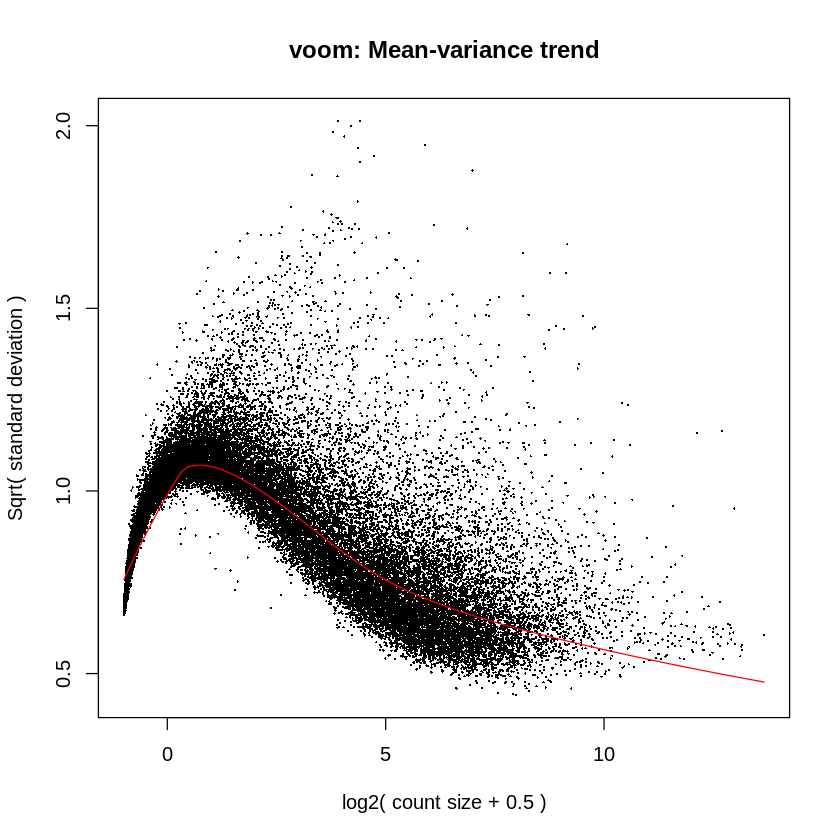

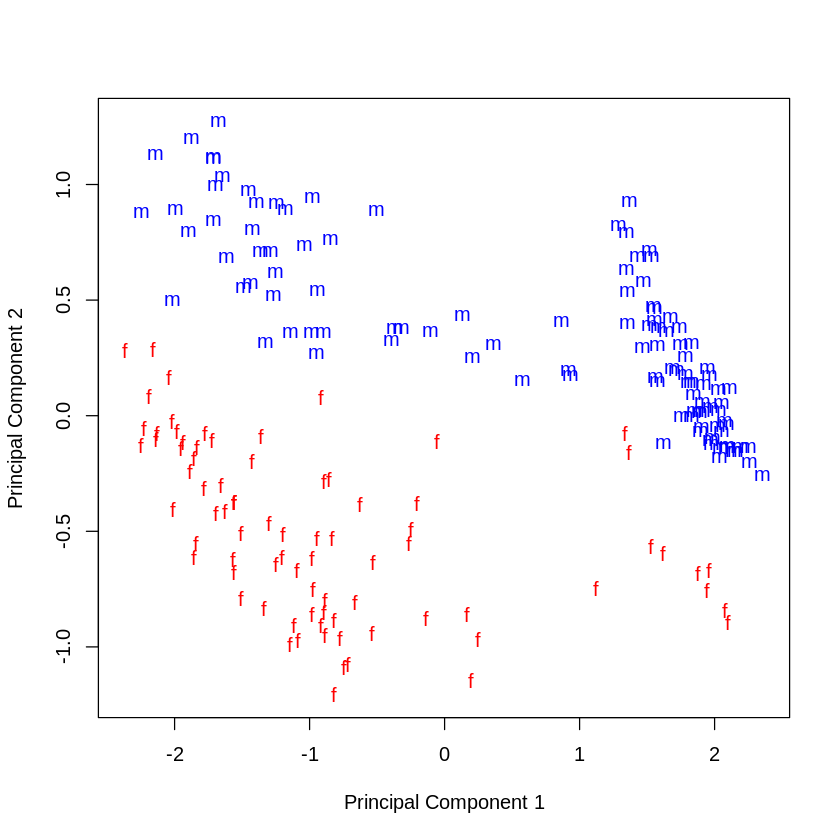

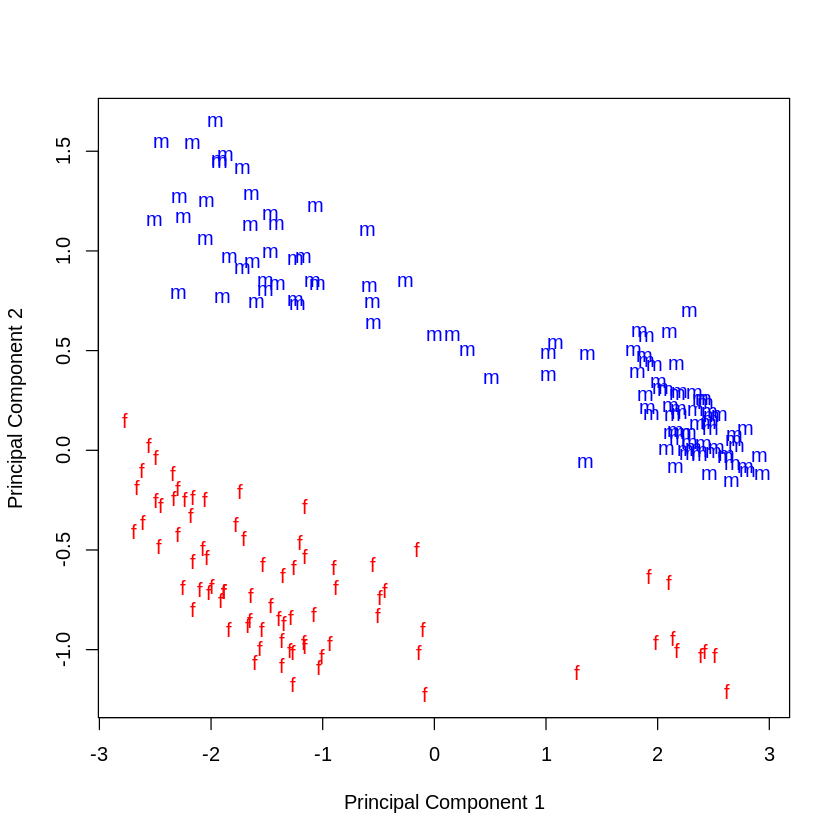

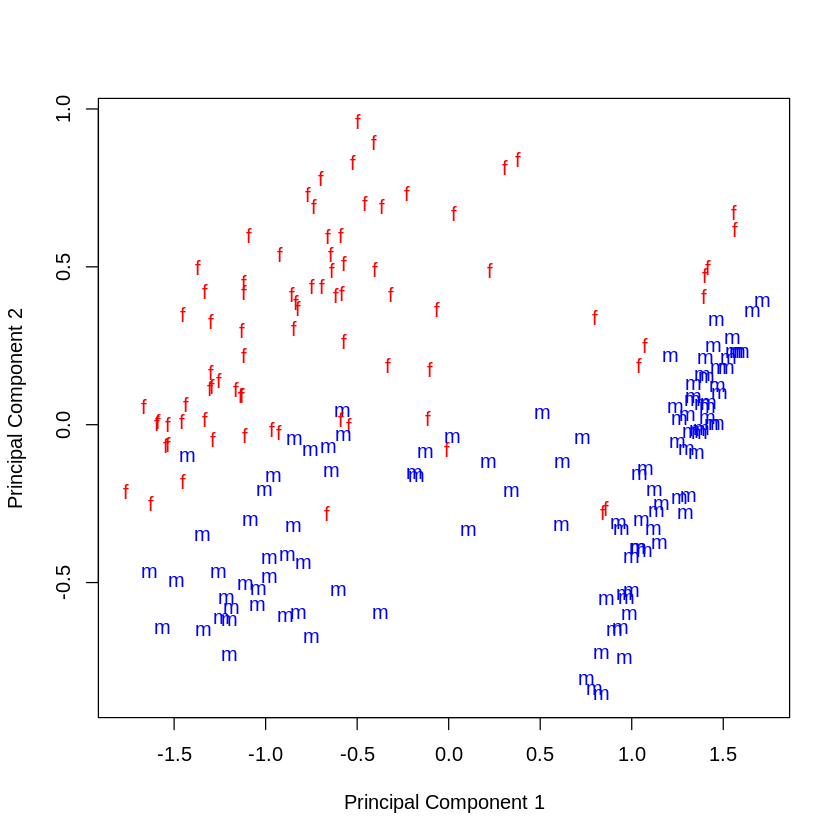

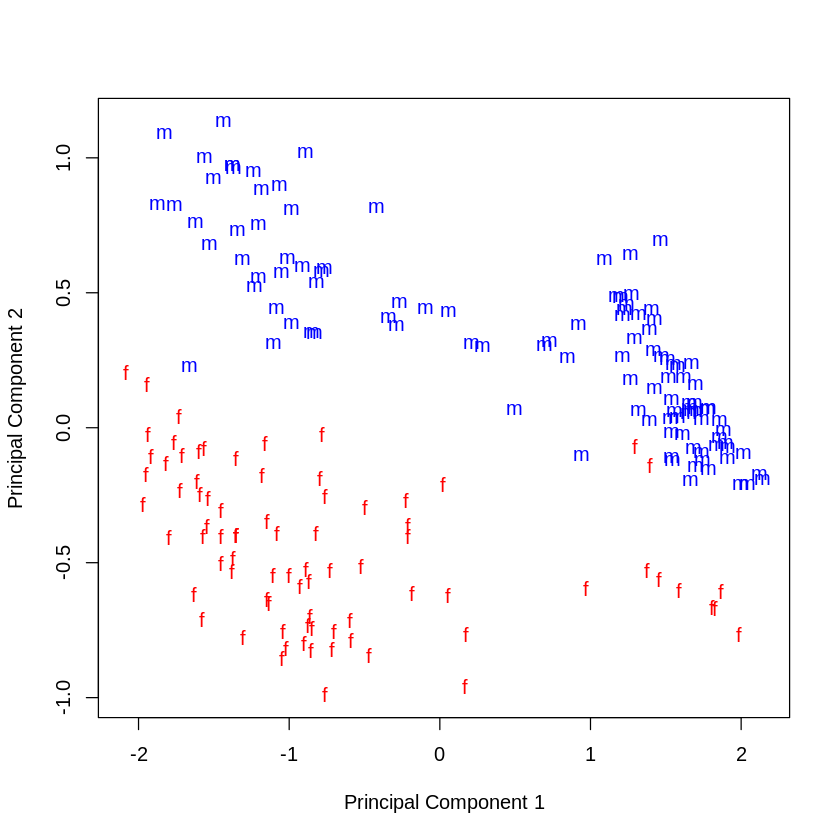

In [23]:
sex    <- factor(reduced.meta.data$sex,levels=c('male','female'))
y <- DGEList(counts=ijc, group = sex)
y <- calcNormFactors(y, method="upperquartile")
sex    <- factor(reduced.meta.data$sex,levels=c('male','female'))
design <- model.matrix ( ~ sex)
y_voom <- voom (y, design=design, plot=TRUE )
Gender <- substring(sex,1,1)

plotMDS(y, labels=Gender, top=500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
plotMDS(y_voom, labels=Gender, top=500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
plotMDS(y, labels=Gender, top=1500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
plotMDS(y_voom, labels=Gender, top=1500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")

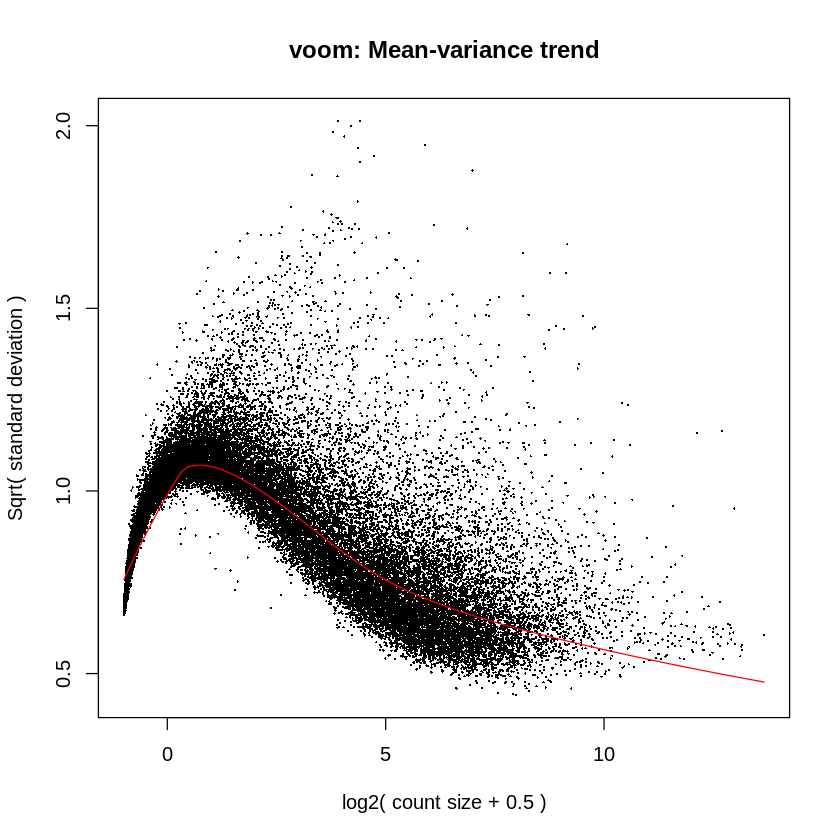

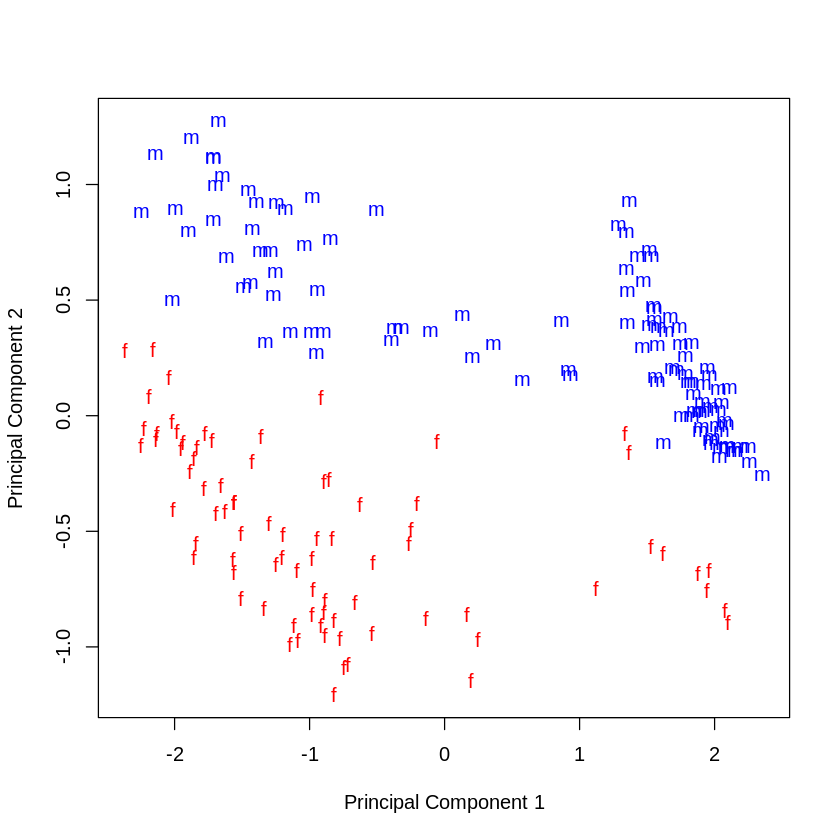

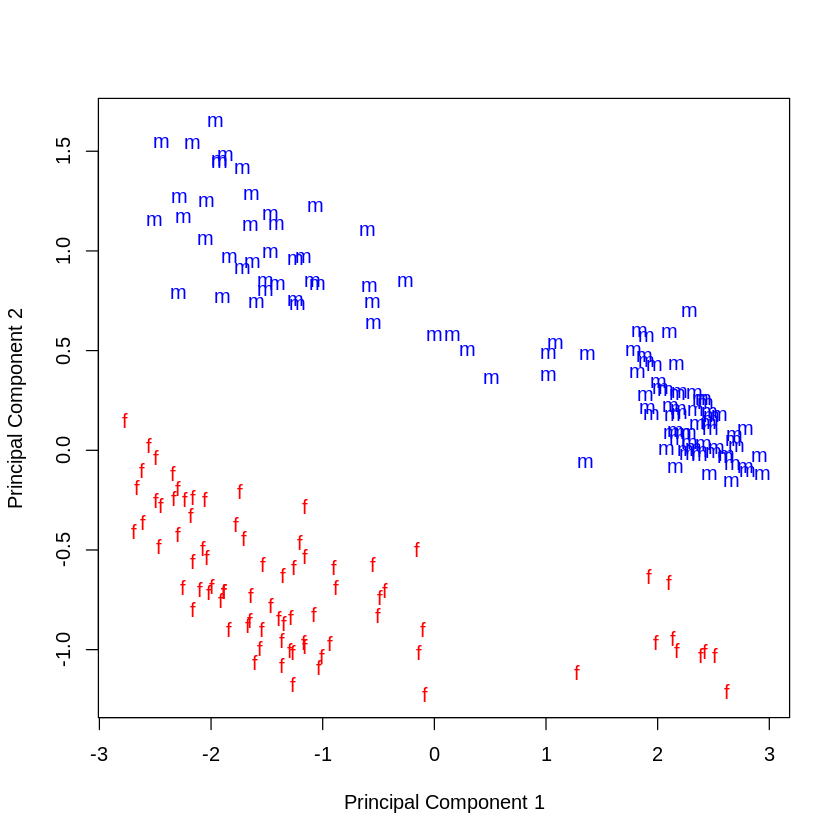

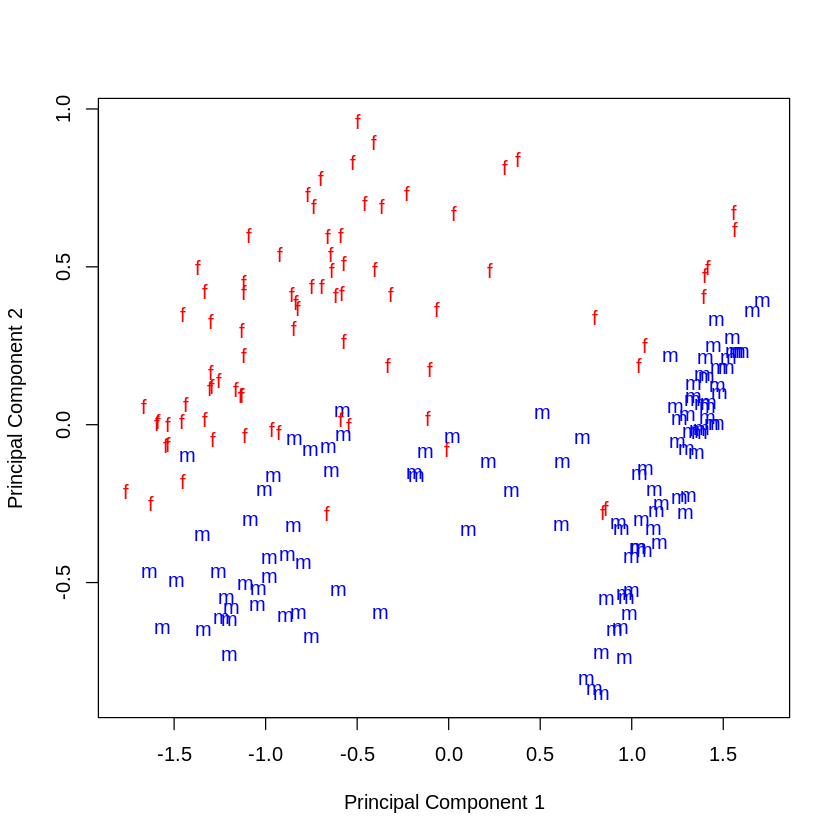

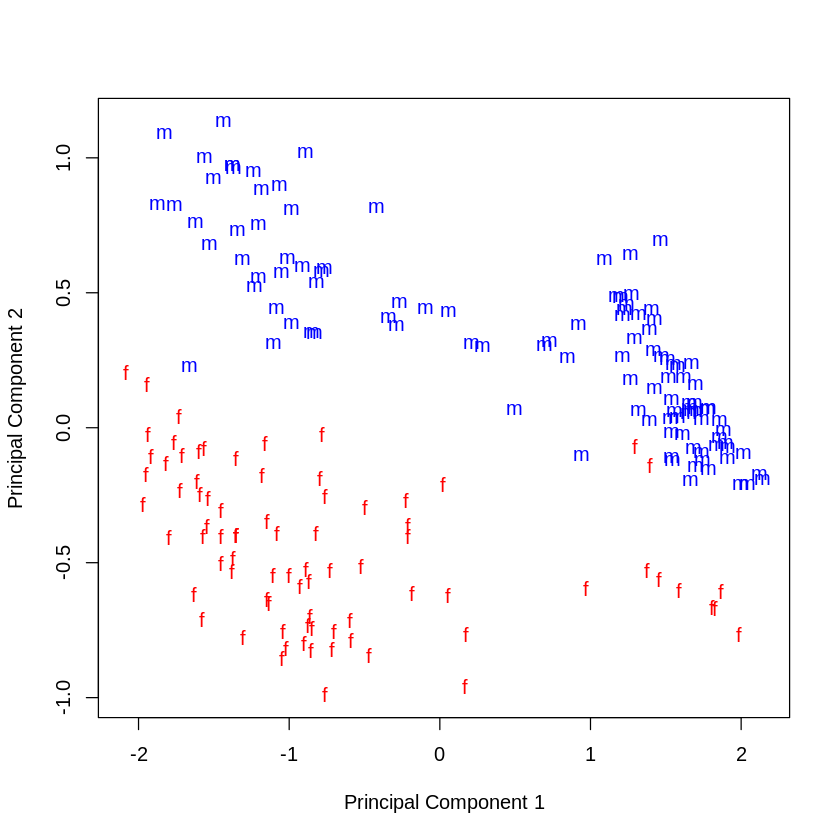

In [24]:
sex       <- factor(reduced.meta.data$sex,levels=c('male','female'))
design    <- model.matrix ( ~ sex)
y <- DGEList(counts=ijc, group = sex)
y <- calcNormFactors(y, method="upperquartile")
sex       <- factor(reduced.meta.data$sex,levels=c('male','female'))
design    <- model.matrix ( ~ sex)
y_voom <- voom (y, design=design, plot=TRUE )
Gender <- substring(sex,1,1)

plotMDS(y, labels=Gender, top=500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
plotMDS(y_voom, labels=Gender, top=500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
plotMDS(y, labels=Gender, top=1500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
plotMDS(y_voom, labels=Gender, top=1500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")


### IJC Plots saved as PDFs

In [25]:
pdf("../pdf/BreastMammaryTissue_ijc_voom.pdf")
y_voom <- voom (y, design=design, plot = TRUE, save.plot = TRUE)
dev.off()

Gender <- substring(sex,1,1)

pdf("../pdf/BreastMammaryTissue_ijc_MDSplot_top500.pdf")
plotMDS(y, labels=Gender, top=500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
dev.off()

pdf("../pdf/BreastMammaryTissue_ijc_voom_MDSplot_top500.pdf")
plotMDS(y_voom, labels=Gender, top=500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
dev.off()

pdf("../pdf/BreastMammaryTissue_ijc_MDSplot_top1500.pdf")
plotMDS(y, labels=Gender, top=1500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
dev.off()

pdf("../pdf/BreastMammaryTissue_ijc_voom_MDSplot_top1500.pdf")
plotMDS(y_voom, labels=Gender, top=1500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
dev.off()



png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

### SJC
sjc counts are skipped exon junction counts -- ijc counts hold together for the top 1000, the skipped exon junction counts fall appart
at a lower number -- around 200!  separation fails between the genders at 250

In [26]:
library(patchwork)
options(repr.plot.width=4.5, repr.plot.height=4)

sex       <- factor(reduced.meta.data$sex,levels=c('male','female'))
design    <- model.matrix(~ sex)
y <- DGEList(counts=sjc, group = sex)
y <- calcNormFactors(y, method="upperquartile")
sex <- factor(reduced.meta.data$sex,levels=c('male','female'))
design <- model.matrix ( ~ sex)

## Differential analysis as_event:ijc 

Differential Analysis (DE) was performed using voom (Law et.al., 2014) to transform junction counts (reads that were aligned to junctions when an exon is included - ijc, and reads that were aligned to junctions when the exon is excluded - sjc) with associated precision weights, followed by linear modeling and empirical Bayes procedure using limma.    In each tissue, the following linear regression model was used to detec secually dimorphic alternative splicing event expression: 

           y = B0 + B1 sex + epsilon (error)
           

where y is the included exon junction count expression; sex denotes the reported sex of the subject.

In [27]:
sex       <- reduced.meta.data$sex
design    <- model.matrix( ~ sex )
colnames(design) <- c("intercept","sex")

y_ijc <- DGEList(counts=ijc, group = sex)
y_ijc <- calcNormFactors(y_ijc, method="upperquartile")
y_ijc_voom <- voom (y_ijc, design=design)

Gender <- substring(sex,1,1)

fit_ijc <- lmFit(y_ijc_voom, design)
fit_ijc <- eBayes(fit_ijc)

ijc_sex_results          <- topTable(fit_ijc, coef='sex', number=nrow(y_voom))
ijc_sex_results[["ID"]]  <- as.integer(rownames(ijc_sex_results))
ijc_sex_results[["AS_site_type"]]  <- AS_site_type
fromGTF.SE <- read.table("../data/fromGTF.SE.txt", header=TRUE)
ijc_sex_results          <- dplyr::left_join(ijc_sex_results, fromGTF.SE, by = "ID")
ijc_sex_results_refined  <- ijc_sex_results$adj.P.Val < 0.05 & abs(ijc_sex_results$logFC) > 1.5

table(ijc_sex_results_refined)
head(ijc_sex_results, 2)

ijc_sex_results_refined
FALSE  TRUE 
42208   403 

,logFC,AveExpr,t,P.Value,adj.P.Val,B,ID,AS_site_type,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
1,5.779693,1.257300,88.63095,5.555877e-160,2.367415e-155,341.1244,19070,SE,ENSG00000183878.15,UTY,chrY,-,13251016,13251187,13248378,13249882,13260277,13260404
2,6.220433,1.489752,84.06363,1.346018e-155,2.867758e-151,333.4615,19076,SE,ENSG00000183878.15,UTY,chrY,-,13306037,13306112,13305398,13305547,13306185,13306250


## Differential analysis as_event:sjc 

Differential Analysis (DE) was performed using voom (Law et.al., 2014) to transform junction counts (reads that were aligned to junctions when an exon is included - ijc, and reads that were aligned to junctions when the exon is excluded - sjc) with associated precision weights, followed by linear modeling and empirical Bayes procedure using limma.    In each tissue, the following linear regression model was used to detec secually dimorphic alternative splicing event expression: 

           y = B0 + B1 sex + epsilon (error)
           

where y is the excluded exon junction count (sjc) expression; sex denotes the reported sex of the subject.

[1] 42611   191

sex
female   male 
    81    110 

,intercept,sex
1,1,0
2,1,0
3,1,0
4,1,0
5,1,1
6,1,1


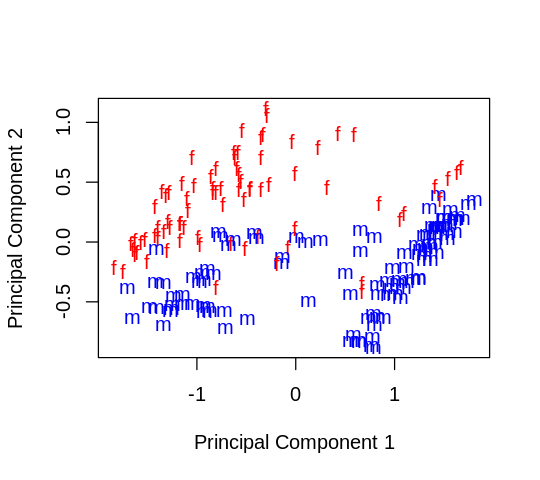

sjc_sex_results_refined
FALSE  TRUE 
42208   403 

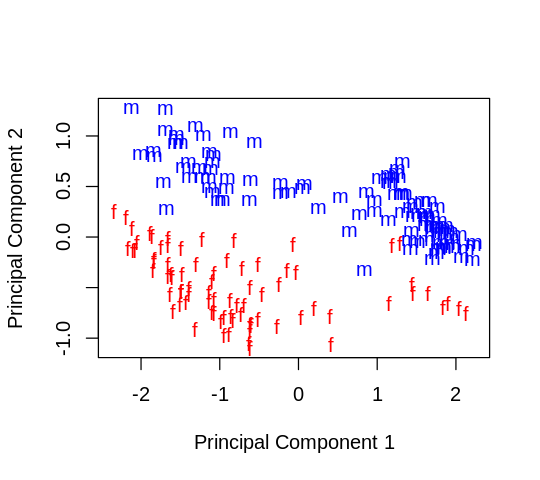

In [28]:
sex       <- reduced.meta.data$sex
design    <- model.matrix( ~ sex )

colnames(design) <- c("intercept","sex")

dim(sjc)
table(sex)
head(design)

y_sjc <- DGEList(counts=sjc, group = sex)
y_sjc <- calcNormFactors(y_sjc, method="upperquartile")

y_sjc_voom <- voom (y_sjc, design=design)

Gender <- substring(sex,1,1)

plotMDS(y_sjc, labels=Gender, top=500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")

plotMDS(y_sjc_voom, labels=Gender, top=500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")

fit_sjc <- lmFit(y_sjc_voom, design)
fit_sjc <- eBayes(fit_sjc)

sjc_sex_results          <- topTable(fit_sjc, coef='sex', number=nrow(y_voom))
sjc_sex_results[["ID"]]  <- as.integer(rownames(ijc_sex_results))
sjc_sex_results[["AS_site_type"]]  <- AS_site_type
sjc_sex_results          <- dplyr::left_join(ijc_sex_results, fromGTF.SE, by = "ID")

sjc_sex_results_refined  <- sjc_sex_results$adj.P.Val < 0.05 & abs(sjc_sex_results$logFC) > 1.5

table(sjc_sex_results_refined)

## Differential analysis as_event (combined ijc and sjc)

Differential Analysis (DE) was performed using voom (Law et.al., 2014) to transform junction counts (reads that were aligned to junctions when an exon is included - ijc, and reads that were aligned to junctions when the exon is excluded - sjc) with associated precision weights, followed by linear modeling and empirical Bayes procedure using limma.    In each tissue, the following linear regression model was used to detec secually dimorphic alternative splicing event expression: 

           y = B0 + B1 sex + B2 as_event + B3 sex*as_event + epsilon (error)
           
         alt_y = B0 + B1 sample + B2 sex + B3 as_event + B4 sex*as_event + epsilon (error)

where y is the alternative splicing event expression; sex denotes the reported sex of the subject, as_event represents the specific alternative splicing event - either included exon junction counts or skipped exon junction counts and their interaction terms.  Modeling the donor and tissue effect as a random effect, for simplicity, we call this sample.


In [29]:
sample    <- c(rep(colnames(ijc.iso.counts.mem2),2))
sample[1:2]

[1] "SRR821498" "SRR808428"

In [30]:
ijc_names <- as.character(colnames(ijc))
sjc_names <- as.character(colnames(sjc))
sjc_names[1:2]

[1] "SRR821498" "SRR808428"

In [31]:
ijc_names <- paste0(ijc_names,"-ijc")
sjc_names <- paste0(sjc_names,"-sjc")
sjc_names[1:2]

[1] "SRR821498-sjc" "SRR808428-sjc"

In [32]:
colnames(ijc) <- ijc_names
colnames(sjc) <- sjc_names
colnames(sjc)[1:2]

[1] "SRR821498-sjc" "SRR808428-sjc"

In [33]:
head(ijc,2)

SRR821498-ijc,SRR808428-ijc,SRR808942-ijc,SRR1090046-ijc,SRR1090674-ijc,SRR1090791-ijc,SRR1091097-ijc,SRR1091791-ijc,SRR1095816-ijc,SRR1096547-ijc,⋯,SRR1420517-ijc,SRR1458335-ijc,SRR1498951-ijc,SRR1489803-ijc,SRR1436990-ijc,SRR1331267-ijc,SRR1100893-ijc,SRR1388281-ijc,SRR1389432-ijc,SRR1310158-ijc
0,0,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
203,202,396,126,130,185,110,87,82,90,⋯,111,91,90,144,145,140,170,49,174,189


In [34]:
as_matrix <- cbind(ijc,sjc)
head(as_matrix, 2)
dim(as_matrix)

SRR821498-ijc,SRR808428-ijc,SRR808942-ijc,SRR1090046-ijc,SRR1090674-ijc,SRR1090791-ijc,SRR1091097-ijc,SRR1091791-ijc,SRR1095816-ijc,SRR1096547-ijc,⋯,SRR1420517-sjc,SRR1458335-sjc,SRR1498951-sjc,SRR1489803-sjc,SRR1436990-sjc,SRR1331267-sjc,SRR1100893-sjc,SRR1388281-sjc,SRR1389432-sjc,SRR1310158-sjc
0,0,0,1,0,0,0,0,0,0,⋯,0,1,1,0,2,0,0,0,0,0
203,202,396,126,130,185,110,87,82,90,⋯,0,0,0,0,0,0,0,0,0,0


[1] 42611   382

In [35]:
sex       <- c(rep(reduced.meta.data$sex,2))
sex       <- factor(sex, levels=c('male','female'))
sex[1:2]
length(sex)

[1] female female
Levels: male female

[1] 382

In [36]:
as_event  <- c(rep("ijc", dim(ijc)[2]), 
               rep("sjc", dim(sjc)[2]))
length(as_event)
as_event[1:2]

[1] 382

[1] "ijc" "ijc"

In [37]:
as_event  <- factor(as_event, levels=c("ijc", "sjc"))
length(as_event)
as_event[1:2]

[1] 382

[1] ijc ijc
Levels: ijc sjc

In this design, we are modeling sample as a random effect - but we could also model it in the design

In [38]:
design    <- model.matrix( ~ sex + as_event + sex*as_event)
head(design,2)
dim(design)

,(Intercept),sexfemale,as_eventsjc,sexfemale:as_eventsjc
1,1,1,0,0
2,1,1,0,0


[1] 382   4

In [39]:
colnames(design) <- c("intercept","sex","as_event","sex*as_event")

length(sample)
dim(as_matrix)
head(as_matrix,2)
table(sex)
table(as_event)
head(design, 2)

[1] 382

[1] 42611   382

SRR821498-ijc,SRR808428-ijc,SRR808942-ijc,SRR1090046-ijc,SRR1090674-ijc,SRR1090791-ijc,SRR1091097-ijc,SRR1091791-ijc,SRR1095816-ijc,SRR1096547-ijc,⋯,SRR1420517-sjc,SRR1458335-sjc,SRR1498951-sjc,SRR1489803-sjc,SRR1436990-sjc,SRR1331267-sjc,SRR1100893-sjc,SRR1388281-sjc,SRR1389432-sjc,SRR1310158-sjc
0,0,0,1,0,0,0,0,0,0,⋯,0,1,1,0,2,0,0,0,0,0
203,202,396,126,130,185,110,87,82,90,⋯,0,0,0,0,0,0,0,0,0,0


sex
  male female 
   220    162 

as_event
ijc sjc 
191 191 

,intercept,sex,as_event,sex*as_event
1,1,1,0,0
2,1,1,0,0


### Voom, limma's lmFit and eBayes

The final factor to model is to capture the impact of the sample (which is a combination of the donor and the tissue - in this single tissue analysis -- it is just the donor) - given that we have so many 

[1] 0.1859776

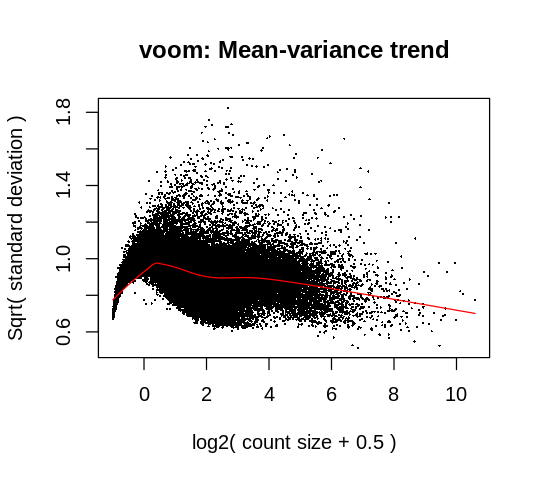

In [40]:
y <- DGEList(counts=as_matrix, group = sex)
y <- calcNormFactors(y, method="upperquartile")
y_no_dup_voom <- voom (y, design=design)
dup_cor <- duplicateCorrelation(y_no_dup_voom$E, 
                                design=design, 
                                ndups=2, 
                                block=sample,
                                weights=y$samples$norm.factors)
dup_cor$consensus.correlation

y_dup_voom <- voom (y, design=design, plot = TRUE, correlation = dup_cor$consensus_correlation)

In [41]:
sample

[1] "SRR821498"  "SRR808428"  "SRR808942"  "SRR1090046" "SRR1090674"
  [6] "SRR1090791" "SRR1091097" "SRR1091791" "SRR1095816" "SRR1096547"
 [11] "SRR1096987" "SRR1098264" "SRR1357826" "SRR1359147" "SRR1361499"
 [16] "SRR1364871" "SRR1365534" "SRR1365622" "SRR1367024" "SRR1429181"
 [21] "SRR1430615" "SRR1433374" "SRR1352457" "SRR1353994" "SRR1356746"
 [26] "SRR1357166" "SRR1079948" "SRR1081023" "SRR1082859" "SRR1083052"
 [31] "SRR1083959" "SRR1084079" "SRR1084674" "SRR1086538" "SRR1086772"
 [36] "SRR811285"  "SRR812198"  "SRR815208"  "SRR820571"  "SRR655852" 
 [41] "SRR656911"  "SRR657528"  "SRR1341100" "SRR1341539" "SRR1342873"
 [46] "SRR1343818" "SRR1345953" "SRR1339236" "SRR1339431" "SRR615910" 
 [51] "SRR1378903" "SRR658105"  "SRR658319"  "SRR658409"  "SRR659223" 
 [56] "SRR660248"  "SRR660283"  "SRR662306"  "SRR662378"  "SRR662811" 
 [61] "SRR1368050" "SRR1369088" "SRR1369584" "SRR1370308" "SRR1378284"
 [66] "SRR1378948" "SRR1380460" "SRR1068977" "SRR1068999" "SRR1070208"
 [71] "SRR1071084" "SRR1071905" "SRR1074860" "SRR1075484" "SRR1076219"
 [76] "SRR1076441" "SRR1077139" "SRR1077920" "SRR1078258" "SRR5125544"
 [81] "SRR5125545" "SRR1437073" "SRR1420936" "SRR1464702" "SRR1473124"
 [86] "SRR1473403" "SRR1481128" "SRR1488586" "SRR1455807" "SRR1469681"
 [91] "SRR1467522" "SRR1475408" "SRR1455861" "SRR1469279" "SRR1485398"
 [96] "SRR1415257" "SRR1328577" "SRR1488694" "SRR1472415" "SRR1472506"
[101] "SRR1472907" "SRR1418729" "SRR1472704" "SRR1475824" "SRR1500709"
[106] "SRR1413392" "SRR1476950" "SRR1486457" "SRR1404887" "SRR1406224"
[111] "SRR1439915" "SRR1417894" "SRR1414661" "SRR1455391" "SRR1456010"
[116] "SRR1459561" "SRR1459866" "SRR1322249" "SRR1415792" "SRR1417725"
[121] "SRR1419656" "SRR1406621" "SRR1386945" "SRR1391511" "SRR1335212"
[126] "SRR1335917" "SRR1391575" "SRR1336181" "SRR1314092" "SRR1323829"
[131] "SRR1327896" "SRR1403814" "SRR1457705" "SRR1408574" "SRR1102949"
[136] "SRR1381799" "SRR1317282" "SRR1318774" "SRR1388399" "SRR1393026"
[141] "SRR1477273" "SRR1409421" "SRR1415420" "SRR1420238" "SRR1407648"
[146] "SRR1498416" "SRR1417422" "SRR1489589" "SRR1099981" "SRR1324206"
[151] "SRR1469237" "SRR1465693" "SRR1435946" "SRR1328941" "SRR1498997"
[156] "SRR1434955" "SRR1409620" "SRR1481297" "SRR1310667" "SRR1420296"
[161] "SRR1410765" "SRR1334587" "SRR1488196" "SRR1458090" "SRR1454158"
[166] "SRR1454009" "SRR1469547" "SRR1490246" "SRR1481315" "SRR1477671"
[171] "SRR1446354" "SRR1386775" "SRR1394912" "SRR1409397" "SRR1486262"
[176] "SRR1100472" "SRR1105009" "SRR1456818" "SRR1396682" "SRR1455902"
[181] "SRR1312822" "SRR1420517" "SRR1458335" "SRR1498951" "SRR1489803"
[186] "SRR1436990" "SRR1331267" "SRR1100893" "SRR1388281" "SRR1389432"
[191] "SRR1310158" "SRR821498"  "SRR808428"  "SRR808942"  "SRR1090046"
[196] "SRR1090674" "SRR1090791" "SRR1091097" "SRR1091791" "SRR1095816"
[201] "SRR1096547" "SRR1096987" "SRR1098264" "SRR1357826" "SRR1359147"
[206] "SRR1361499" "SRR1364871" "SRR1365534" "SRR1365622" "SRR1367024"
[211] "SRR1429181" "SRR1430615" "SRR1433374" "SRR1352457" "SRR1353994"
[216] "SRR1356746" "SRR1357166" "SRR1079948" "SRR1081023" "SRR1082859"
[221] "SRR1083052" "SRR1083959" "SRR1084079" "SRR1084674" "SRR1086538"
[226] "SRR1086772" "SRR811285"  "SRR812198"  "SRR815208"  "SRR820571" 
[231] "SRR655852"  "SRR656911"  "SRR657528"  "SRR1341100" "SRR1341539"
[236] "SRR1342873" "SRR1343818" "SRR1345953" "SRR1339236" "SRR1339431"
[241] "SRR615910"  "SRR1378903" "SRR658105"  "SRR658319"  "SRR658409" 
[246] "SRR659223"  "SRR660248"  "SRR660283"  "SRR662306"  "SRR662378" 
[251] "SRR662811"  "SRR1368050" "SRR1369088" "SRR1369584" "SRR1370308"
[256] "SRR1378284" "SRR1378948" "SRR1380460" "SRR1068977" "SRR1068999"
[261] "SRR1070208" "SRR1071084" "SRR1071905" "SRR1074860" "SRR1075484"
[266] "SRR1076219" "SRR1076441" "SRR1077139" "SRR1077920" "SRR1078258"
[271] "SRR5125544" "SRR5125545" "SRR1437073" "SRR1420936" "SRR1464702"
[276] "SRR1473124" "SRR1473403" "SRR1481128" "SRR1488586" "SRR1455807"
[281] "SRR1469681" "SRR146

In [42]:
dup_cor <- duplicateCorrelation(y_no_dup_voom$E, design=design, ndups=2, block=sample, weights=y$samples$norm.factors)
dup_cor$consensus.correlation

[1] 0.1859776

In [ ]:
y_dup_voom <- voom (y, design=design, plot = TRUE, correlation = dup_cor$consensus_correlation)

In [ ]:
Gender <- substring(sex[1:191],1,1)

plotMDS(y_no_dup_voom[,c(1:191)], labels=Gender, top=500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")

In [ ]:
plotMDS(y_dup_voom[,c(1:191)], labels=Gender, top=500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")

In [ ]:
pdf ("../pdf/BreastMammaryTissue_y_no_dup_voom_top_500.pdf")
plotMDS(y_no_dup_voom[,c(1:191)], labels=Gender, top=500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
dev.off()
pdf ("../pdf/BreastMammaryTissue_y_dup_voom_top_500.pdf")
plotMDS(y_dup_voom[,c(1:191)], labels=Gender, top=500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
dev.off()

### linear fit with eBayes

With a correlation of 0.19 the two measures ijc and sjc are weakly correlated per donor. Which is to be expected, as for any single donor one would expect that the inclusion of an exon would result in the increase in the inclusion junction counts (reads aligned to the junctions associated with the included exon) and not expect that that same donor would have also evidence of excluded exon (where the counts would be to the junction revealed by the exon being excluded).   However, some amount of correlation might be here because of a haplotype affect and the location being on one allele maternally inherited versions another allele paternally inherited. 

Nevertheless, we include the duplicate correlation as calculated in our analysis.

In [ ]:
fit <- lmFit(y_dup_voom, design)
fit <- eBayes(fit, robust = TRUE)

In [ ]:
sex_as_events_results         <- topTable(fit, coef="sex*as_event", number=nrow(y_no_dup_voom))
sex_as_events_results[["ID"]] <- as.integer(rownames(ijc_sex_results))
sex_as_events_results[["AS_site_type"]]  <- AS_site_type
sex_as_events_results[["featurespace"]] <- "sex*as_event"
sex_as_events_results         <- dplyr::left_join(sex_as_events_results, fromGTF.SE, by = "ID")

sex_as_events_results_refined <- sex_as_events_results$adj.P.Val < 0.05 & abs(sex_as_events_results$logFC) > 1.5

sex_results                   <- topTable(fit, coef="sex", number=nrow(y_no_dup_voom))
sex_results[["ID"]]           <- as.integer(rownames(sex_results))
sex_results[["AS_site_type"]] <- AS_site_type
sex_results[["featurespace"]] <- "sex"
sex_results                   <- dplyr::left_join(sex_results, fromGTF.SE, by = "ID")

sex_results_refined           <- sex_results$adj.P.Val < 0.05 & abs(sex_results$logFC) > 1.5

table(sex_as_events_results_refined)
table(sex_results_refined)

#### fromGTF

rMATS analyzes the gtf file and determines the junctions, identifying 10 matrices in all.  The fromGTF.SE.txt contains the annotation information and we can use this information to estimate the duplicate correlation effect from counting based upon the same gene with our ijc counts.  we will use this information, to obtain the gene information.


In [ ]:
ijc_sex_results          <- topTable(fit_ijc, coef='sex', number=nrow(y_ijc_voom))
ijc_sex_results[["ID"]]           <- as.integer(rownames(ijc_sex_results))
ijc_sex_results[["AS_site_type"]] <- AS_site_type
ijc_sex_results[["featurespace"]] <- "ijc"
ijc_sex_results                   <- dplyr::left_join(ijc_sex_results, fromGTF.SE, by = "ID")

sjc_sex_results                   <- topTable(fit_sjc, coef='sex', number=nrow(y_sjc_voom))
sjc_sex_results[["ID"]]           <- as.integer(rownames(sjc_sex_results))
sjc_sex_results[["AS_site_type"]] <- AS_site_type
sjc_sex_results[["featurespace"]] <- "sjc"
sjc_sex_results                   <- dplyr::left_join(sjc_sex_results, fromGTF.SE, by = "ID")

In [ ]:
head(ijc_sex_results,2)
head(sjc_sex_results,2)
head(sex_as_events_results, 2)
head(sex_results, 2)

In [ ]:
dim(sex_as_events_results)
dim(sex_results)

In [ ]:
sex_as_events_filename         = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_DGE_sex_as_events.csv',sep='')
sex_filename                   = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_DGE_sex.csv',sep='')
ijc_sex_filename               = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_DGE_ijc_sex.csv',sep='')
sjc_sex_filename               = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_DGE_sjc_sex.csv',sep='')

In [ ]:
data.table::fwrite(sex_as_events_results, file = sex_as_events_filename, sep = ",")
data.table::fwrite(sex_results,           file = sex_filename          , sep = ",")
data.table::fwrite(ijc_sex_results,       file = ijc_sex_filename      , sep = ",")
data.table::fwrite(sjc_sex_results,       file = sjc_sex_filename      , sep = ",")

## Metadata

For replicability and reproducibility purposes, we also print the following metadata:

1. Checksums of **'artefacts'**, files generated during the analysis and stored in the folder directory **`data`**
2. List of environment metadata, dependencies, versions of libraries using `utils::sessionInfo()` and [`devtools::session_info()`](https://devtools.r-lib.org/reference/session_info.html)

### 1. Checksums with the sha256 algorithm

In [ ]:
notebookid   = "BreastMammaryTissueJunctionAnalysis"

message("Generating sha256 checksums of the artefacts in the `..data/` directory .. ")
system(paste0("cd ../data && find . -type f -exec sha256sum {} \\;  >  ../metadata/", notebookid, "_sha256sums.txt"), intern = TRUE)
message("Done!\n")

data.table::fread(paste0("../metadata/", notebookid, "_sha256sums.txt"), header = FALSE, col.names = c("sha256sum", "file"))

### 2. Libraries metadata

In [ ]:
dev_session_info   <- devtools::session_info()
utils_session_info <- utils::sessionInfo()

message("Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..")
saveRDS(dev_session_info, file = paste0("../metadata/", notebookid, "_devtools_session_info.rds"))
message("Done!\n")

message("Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..")
saveRDS(utils_session_info, file = paste0("../metadata/", notebookid ,"_utils_info.rds"))
message("Done!\n")

dev_session_info$platform
dev_session_info$packages[dev_session_info$packages$attached==TRUE, ]